# Bulk data process

1. Read associations
2. Drop all mouse evidence
3. Group by associations
4. Calculate harmonic sum to get association score
5. Annotate disease if haematologically relevant or not


## For stats

1. Get a relevant set of genes from reactome
2. Generate an equivalent set of genes by random

## Stats

1. Apply score threshold for association -> Get average count of hematological diseases
2. Apply score threshold for association -> for each gene, compare median association for every vs. hematological traits. -> calculate average
3. 

In [1]:
%%bash 


# Fetching associations from google:
gsutil cp -r gs://open-targets-data-releases/22.06/output/etl/parquet/associationByDatatypeDirect /Users/dsuveges/project_data/
# gsutil cp -r gs://open-targets-data-releases/22.06/output/etl/parquet/targets /Users/dsuveges/project_data/

# The same data can be found on ftp: ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/22.06/output/etl/parquet

# Fetching efo dataset from the platform:
# wget https://platform.opentargets.org/data/ontology/efo_json/diseases_efo.jsonl -O diseases_efo.json

ls -lah *json

-rw-r--r--  1 dsuveges  384566875   2.4M 24 Jun 11:17 diseases_efo.json


Copying gs://open-targets-data-releases/22.06/output/etl/parquet/associationByDatatypeDirect/_SUCCESS...
Copying gs://open-targets-data-releases/22.06/output/etl/parquet/associationByDatatypeDirect/part-00000-8d9107f6-e36d-4d36-a4ed-66c4c59bc87d-c000.snappy.parquet...
Copying gs://open-targets-data-releases/22.06/output/etl/parquet/associationByDatatypeDirect/part-00001-8d9107f6-e36d-4d36-a4ed-66c4c59bc87d-c000.snappy.parquet...
Copying gs://open-targets-data-releases/22.06/output/etl/parquet/associationByDatatypeDirect/part-00002-8d9107f6-e36d-4d36-a4ed-66c4c59bc87d-c000.snappy.parquet...
- [4 files][416.3 KiB/416.3 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://open-targets-data-releases/22.06/output/etl/parquet/assoc

In [1]:
from statistics import median

import pyspark.sql
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql.window import Window


spark = (
    pyspark.sql.SparkSession
   .builder
   .master("local[*]")
   .getOrCreate()
)
   
@f.udf(t.FloatType())
def harmonic_sum(data: list, scale_factor: float = 1, cap: float = None) -> float:
    """
    Returns an harmonic sum for the data passed
    Args:
        data (list): list of floats to compute the harmonic sum from
        scale_factor (float): a scaling factor to multiply to each datapoint. Defaults to 1
        cap (float): if not None, never return an harmonic sum higher than the cap value.
    Returns:
        harmonic_sum (float): the harmonic sum of the data passed
    """

    data.sort(reverse=True)
    harmonic_sum = sum(s / ((i+1) ** scale_factor) for i, s in enumerate(data))
    
    # Applying cap:
    if cap is not None and harmonic_sum > cap:
        return cap
      
    return harmonic_sum

# An UDF to calculate median:
median_udf = f.udf(lambda l: median([x for x in l if x >= 1]), t.FloatType())

association_dataset = '/Users/dsuveges/project_data/associationByDatatypeDirect'
disease_dataset = '/Users/dsuveges/project/random_notebooks/2022.06.08-disease_expansion/diseases_efo.json'

### Processing disease table

1. Reading json into spark table.
2. Exploding parent table.
3. Annotate each disease if the disease or the parent is haematologically relevant
4. Aggregate annotation for each disease.

In [128]:
relevant_disease_pattern = ['immuno', 'hemato', 'hemo', 'blood', 'bleed']


disease_raw = (
    spark.read.json(disease_dataset)
    .withColumnRenamed('id', 'diseaseId')
    .withColumnRenamed('name', 'diseaseLabel')
    .persist()
)

annotated_diseases = (
    disease_raw
    # Exploding parent column:
    .select('diseaseId', 'diseaseLabel', f.explode_outer('parentIds').alias('parentId'))
    
    # Get parent disease names:
    .join(
        (
            disease_raw
            .withColumnRenamed('diseaseId', 'parentId')
            .withColumnRenamed('diseaseLabel', 'parentLabel')
            .drop('parentIds')
        ), on='parentId', how='left')
    
    # Check if disease name OR parent name is relevant:
    .withColumn(
        'isRelevant',
        f.when(f.col('diseaseLabel').rlike('|'.join(relevant_disease_pattern)), True)
        .when(f.col('parentLabel').rlike('|'.join(relevant_disease_pattern)), True)
        .otherwise(False)
    )
    
    # Aggregating by disease, check if at least one parent is relevant:
    .groupBy('diseaseId', 'diseaseLabel')
    .agg(
        f.expr("any(isRelevant)").alias('isRelevant')
    )
    .withColumn(
        'isRelevant',
        f.when(f.col('isRelevant') == True, 'relevant')
        .otherwise('not_relevant')
    )
    .persist()
)

annotated_diseases.filter(f.col('isRelevant') == 'relevant').count()


1411

### Reading targets

1. Read parquet and select columns

In [58]:
targets = (
    spark.read.parquet('/Users/dsuveges/project_data/targets')
    .select(
        f.col('id').alias('targetId'),
        f.col('approvedSymbol').alias('targetSymbol'),
        f.col('approvedName').alias('targetName')
    )
    .persist()
)

### Processing associations

1. Read assoction file
2. Drop animal model data
3. Aggregating associations
4. Calcualte harmonic sum
5. Join disease info
6. Join target info

In [54]:
print(f'Number of all associations: {spark.read.parquet(association_dataset).select("diseaseId", "targetId").distinct().count()}')

no_animal_associations = (
    spark.read.parquet(association_dataset)
    .filter(f.col('datatypeId') != 'animal_model')
    .select("diseaseId", "targetId").distinct()
)

print(f'Number of associations supported by sources not including mouse: {no_animal_associations.count()}')


Number of all associations: 2120908
Number of associations supported by sources not including mouse: 1614569


In [130]:
assoc_df = (
    # Reading associations:
    spark.read.parquet(association_dataset)

    # Dropping all animal model data:
    .filter(f.col('datatypeId') != 'animal_model')

    # aggregating by association and calculate overall score:
    .groupBy('diseaseId', 'targetId')
    .agg(harmonic_sum(f.collect_list(f.col('score'))).alias('overall_score'))

    # Joining with diseases and disease annotation.
    .join(annotated_diseases, on='diseaseId')
    
    # Joining with target annotation:
    .join(targets, on='targetId', how='left')
    .persist()
)

# How does it look like:
assoc_df.show()

# Saving data in a partitioned parquet:
assoc_df.write.mode('overwrite').parquet('Associations_w_disease_annot')

# Saving data in a single tsv file:
assoc_df.toPandas().to_csv('annotated_associations.tsv.gz', sep='\t', compression='infer', index=False)

+---------------+----------+-------------+--------------------+------------+------------+--------------------+
|       targetId| diseaseId|overall_score|        diseaseLabel|  isRelevant|targetSymbol|          targetName|
+---------------+----------+-------------+--------------------+------------+------------+--------------------+
|ENSG00000113749|DOID_10718| 0.0121586155|          giardiasis|not_relevant|        HRH2|histamine recepto...|
|ENSG00000120937|DOID_13406|  0.018237924|pulmonary sarcoid...|not_relevant|        NPPB|natriuretic pepti...|
|ENSG00000066427| DOID_7551| 0.0121586155|           gonorrhea|not_relevant|       ATXN3|            ataxin 3|
|ENSG00000095739| DOID_7551|   0.03039654|           gonorrhea|not_relevant|       BAMBI|BMP and activin m...|
|ENSG00000102755| DOID_7551|   0.18691845|           gonorrhea|not_relevant|        FLT1|fms related recep...|
|ENSG00000103335| DOID_7551|    0.5912127|           gonorrhea|not_relevant|      PIEZO1|piezo type mechan...|
|

## Analysis

In [131]:
aggregated_associations = (
    assoc_df
    
    # Applying a filter based on the overall score: 
    # iteratively we can adjust this to make sure we are not too stringent
    .filter(
        (f.col('overall_score') >= 0.1)
    )
    
    # Grouping data by target and the relevance flag:
    .groupby('targetId', 'targetName', 'targetSymbol')
    .pivot('isRelevant')
    .agg(
        f.max(f.col('overall_score')).alias('max'),
        f.mean(f.col('overall_score')).alias('mean_score'),
        f.count(f.col('overall_score')).alias('disease_count'),
        median_udf(f.collect_list(f.col('overall_score'))).alias('median_score'),
    )
    .persist()
)

aggregated_associations.count()

# Saving data in in tsv:
(
    aggregated_associations
    .toPandas()
    .to_csv('aggregated_associations.tsv.gz', sep='\t', index=False)
)

23738

In [135]:
aggregated_associations.filter(f.col('targetSymbol') == 'DYNLL1').show(vertical=True)

-RECORD 0------------------------------------------
 targetId                   | ENSG00000088986      
 targetName                 | dynein light chai... 
 targetSymbol               | DYNLL1               
 not_relevant_max           | 0.918321             
 not_relevant_mean_score    | 0.32031524001524364  
 not_relevant_disease_count | 29                   
 not_relevant_median_score  | 0.21566625           
 relevant_max               | 0.33030993           
 relevant_mean_score        | 0.23655396550893784  
 relevant_disease_count     | 5                    
 relevant_median_score      | 0.2565868            



In [136]:
print(f'Number of targets: {aggregated_associations.count()}')
print(f'Number of targets with blood related diseases: {aggregated_associations.filter(f.col("relevant_disease_count")>0).count()}')



Number of targets: 23738
Number of targets with blood related diseases: 11186


<AxesSubplot:>

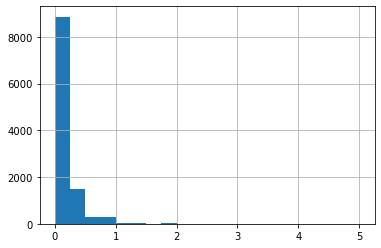

In [144]:
(
    aggregated_associations
    .filter(f.col("relevant_disease_count")>0)
    .withColumn('diseaseRatio', f.col('relevant_disease_count')/f.col('not_relevant_disease_count'))
    .select('diseaseRatio')
    .toPandas().diseaseRatio
    .hist(bins=20)
)

<AxesSubplot:>

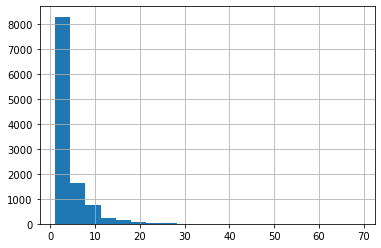

In [145]:
(
    aggregated_associations
    .filter(f.col("relevant_disease_count")>0)
    .toPandas().relevant_disease_count
    .hist(bins=20)
)

In [149]:
(
    aggregated_associations
    .filter(f.col("relevant_disease_count")>0)
    .select('relevant_disease_count', 'relevant_median_score')
    .describe()
    .show()
)

+-------+----------------------+---------------------+
|summary|relevant_disease_count|relevant_median_score|
+-------+----------------------+---------------------+
|  count|                 11186|                11186|
|   mean|    3.6915787591632396|   0.2960715356427592|
| stddev|     4.202942396095931|  0.16069814713459626|
|    min|                     1|          0.100007325|
|    max|                    69|            1.2845116|
+-------+----------------------+---------------------+



In [175]:
blood_related_genes = (
    spark.read.parquet('/Users/dsuveges/project_data/targets')
    .withColumn('functionDescription', f.explode('functionDescriptions'))
    .filter(f.col('functionDescription').rlike(r'blood|erythro|hemato|haemo'))
    .select('approvedSymbol')
    .withColumnRenamed('approvedSymbol', 'targetSymbol')
    .distinct()
    .sample(0.5)
    .persist()
)

random_genes = (
    spark.read.parquet('/Users/dsuveges/project_data/targets')
    .select('approvedSymbol')
    .withColumnRenamed('approvedSymbol', 'targetSymbol')
    .sample(0.5)
    .limit(blood_related_genes.count())
    .persist()
)

print(f'Number of blood related genes: {blood_related_genes.count()}')
print(f'Number of randomly selected genes: {random_genes.count()}')

Number of blood related genes: 295
Number of randomly selected genes: 295


In [180]:
# Extract annotations for blood releated genes:
blood_annotated = (
    aggregated_associations
    .join(blood_related_genes, on='targetSymbol')
    .withColumn('source', f.lit('blood'))
)

# Extract annotation for the other gene set:
random_annotated = (
    aggregated_associations
    .join(random_genes, on='targetSymbol')
    .withColumn('source', f.lit('random'))
)

# Take union of the two sets:
combined_dataset = (
    blood_annotated
    .union(random_annotated)
    .persist()
)

combined_dataset.count()

577

In [218]:
median_udf = f.udf(lambda l: median([x for x in l if x >= 1]), t.FloatType())

stats = (
    combined_dataset
    .groupBy('source')
    .agg(
        median_udf(f.collect_list(f.col('relevant_median_score'))).alias('median-relevant-median-score'),
        median_udf(f.collect_list(f.col('not_relevant_median_score'))).alias('median-not-relevant-median-score'),
        median_udf(f.collect_list(f.col('relevant_disease_count'))).alias('median-relevant-disease-count'),
        median_udf(f.collect_list(f.col('not_relevant_disease_count'))).alias('median-not-relevant-disease-count')

    )
    .persist()
)


# unpivot_expression = '''stack(2, 'farm1', farm1_count, 'farm2', farm2_count) as (farm, count)'''

# unpivot_expression = '''stack(2, 'farm1', farm1_count, 'farm2', farm2_count) as (farm, count)'''

# (
#     df
#     .select('animal', 'voice', expr(unpivot_expression))
#     .show()
# )

stats.show()

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 211, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 132, in dump_stream
    for obj in iterator:
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 200, in _batched
    for item in iterator:
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in mapper
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in <genexpr>
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-217-fd6e94f69a68>", line 40, in <lambda>
  File "/Users/dsuveges/opt/anaconda3/envs/jupyter3.9/lib/python3.9/statistics.py", line 430, in median
    raise StatisticsError("no median for empty data")
statistics.StatisticsError: no median for empty data


In [235]:
median_udf = f.udf(lambda l: median([x for x in l if x >= 1]), t.FloatType())


(
    combined_dataset
    .groupby('source')
    .agg(
        f.percentile_approx(f.collect_list('relevant_disease_count')).alias('y'),
        f.collect_list('relevant_disease_count').alias('x')
    )
    .show()
)
# median(l)

TypeError: percentile_approx() missing 1 required positional argument: 'percentage'

In [264]:
from functools import partial

l = [10, 20, 6, 4323, 12, 32, 12, 342]
bp = [2, 4, 7]

[l[b[0]:b[1]] for b in zip([0] + bp, bp + [len(l)])]


[[10, 20], [6, 4323], [12, 32, 12], [342]]

In [242]:


reduce(lambda b, l: l[b[0]:b[1]], zip([0]+break_points, break_points + [len(l)]))

IndexError: tuple index out of range

In [244]:
?partial

In [247]:
x = partial(lambda l, b: l[b[0]:b[1]], l=l )

In [250]:
[b for b in map(x, zip([0]+break_points, break_points + [len(l)]))]

TypeError: <lambda>() got multiple values for argument 'l'

In [262]:
[l[b[0]:b[1]] for b in zip([0]+break_points, break_points + [len(l)])]


[[10, 20], [6, 4323], [12, 32, 12], [342]]

In [261]:
list(map(lambda l, b: , b, l))

TypeError: 'int' object is not subscriptable

In [3]:
type(spark)

pyspark.sql.session.SparkSession

In [2]:
def test():
    print(spark.version)
    
test()

3.1.2
